In [29]:
!pip install sagemaker --upgrade



/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## Setup All Workshop Dependencies

In [ ]:
!pip install sagemaker --upgrade
#Install TensorFlow
!pip install --disable-pip-version-check -q tensorflow==2.3.1

#Install Hugging Face Transformers (BERT)
!pip install --disable-pip-version-check -q transformers==3.5.1


https://towardsdatascience.com/huggingface-processing-jobs-on-amazon-sagemaker-b1f5af97b663

In [2]:
from botocore.exceptions import ClientError

import os
import sagemaker
import logging
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

import botocore.config

config = botocore.config.Config(
    user_agent_extra='dsoaws/1.0'
)

sm = boto3.Session().client(service_name="sagemaker", 
                            region_name=region,
                            config=config)
s3 = boto3.Session().client(service_name="s3", 
                            region_name=region,
                            config=config)

## 1. Load Dataset

https://s3.amazonaws.com/amazon-reviews-pds/readme.html


<img src="img/Dataset_Info.png">

In [3]:
!aws s3 ls s3://amazon-reviews-pds/tsv/


2017-11-24 13:22:50          0 
2017-11-24 13:48:03  241896005 amazon_reviews_multilingual_DE_v1_00.tsv.gz
2017-11-24 13:48:17   70583516 amazon_reviews_multilingual_FR_v1_00.tsv.gz
2017-11-24 13:48:34   94688992 amazon_reviews_multilingual_JP_v1_00.tsv.gz
2017-11-24 13:49:14  349370868 amazon_reviews_multilingual_UK_v1_00.tsv.gz
2017-11-24 13:48:47 1466965039 amazon_reviews_multilingual_US_v1_00.tsv.gz
2017-11-24 13:49:53  648641286 amazon_reviews_us_Apparel_v1_00.tsv.gz
2017-11-24 13:56:36  582145299 amazon_reviews_us_Automotive_v1_00.tsv.gz
2017-11-24 14:04:02  357392893 amazon_reviews_us_Baby_v1_00.tsv.gz
2017-11-24 14:08:11  914070021 amazon_reviews_us_Beauty_v1_00.tsv.gz
2017-11-24 14:17:41 2740337188 amazon_reviews_us_Books_v1_00.tsv.gz
2017-11-24 14:45:50 2692708591 amazon_reviews_us_Books_v1_01.tsv.gz
2017-11-24 15:10:21 1329539135 amazon_reviews_us_Books_v1_02.tsv.gz
2017-11-24 15:22:13  442653086 amazon_reviews_us_Camera_v1_00.tsv.gz
2017-11-24 15:27:13 2689739299 amazon_rev

In [4]:

!aws s3 cp  s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz .
#!aws s3 cp  s3://amazon-reviews-pds/tsv/sample_us.tsv .

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to ./amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
df = pd.read_csv('./amazon_reviews_us_Digital_Software_v1_00.tsv.gz', parse_dates=['review_date'], compression='gzip',sep='\t')
#df = pd.read_csv('./amazon_reviews_us_Music_v1_00.tsv.gz', compression='gzip',sep='\t', nrows=100)
#df = pd.read_csv('./sample_us.tsv',sep='\t')

In [7]:
df.head()


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


## 2. Data Visualization

### 2.1 How many reviews per Star Rating? (5, 4, 3, 2, 1)

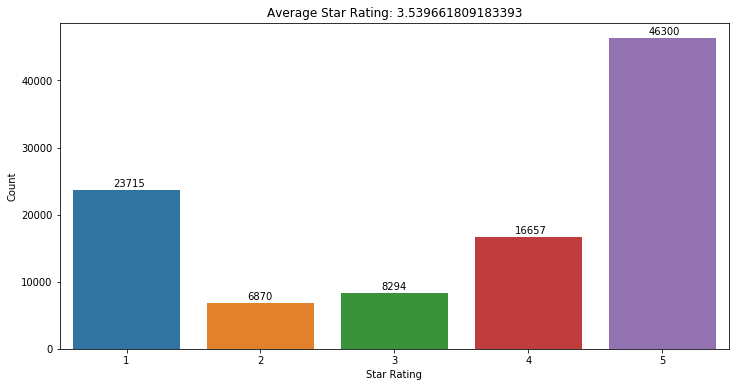

In [8]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="star_rating", data=df)
plt.title('Average Star Rating: {}'.format(df['star_rating'].mean()))
plt.xlabel('Star Rating')
plt.ylabel('Count')

for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+500))

### 2.2 How many reviews per Year?

In [9]:
df['review_year'] =df['review_date'].dt.year

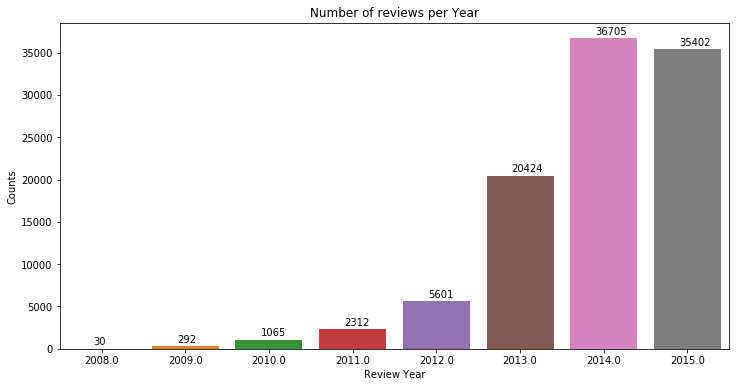

In [10]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="review_year", data=df)
plt.title('Number of reviews per Year')
plt.xlabel('Review Year')
plt.ylabel('Counts')

for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+500))

### 2.3 How Did Star Ratings Change Over Time?

Text(0, 0.5, 'Average Rating')

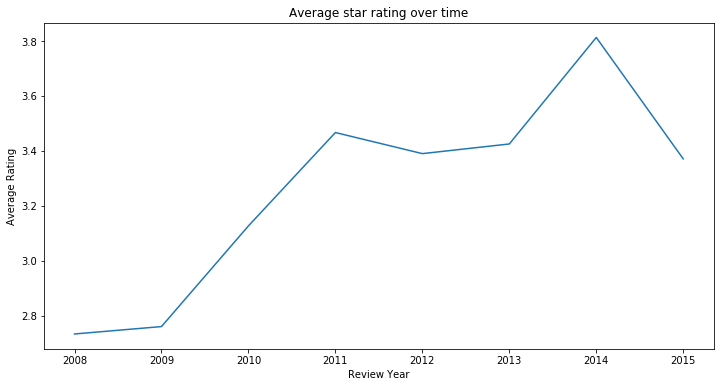

In [11]:
plt.figure(figsize=(12,6))
ax = df.groupby(['review_year']).star_rating.mean().plot()

plt.title('Average star rating over time')
plt.xlabel('Review Year')
plt.ylabel('Average Rating')


### 2.4 Which Star Ratings (1-5) are Most Helpful?

In [12]:
pd.set_option('display.max_colwidth', 1000)
df.sort_values(by=['helpful_votes'],  ascending=False)[['review_id','star_rating','helpful_votes','review_body']].head()

,review_id,star_rating,helpful_votes,review_body
38811,RCCP4PH9KE2UB,1,5363,"I have been a loyal TurboTax customer since sometime in the 90's (I threw away the floppy disks a long time ago, and I don't recall the earliest date, but it's been a long time.) I am angry about the deliberate disabling of critical features in TurboTax Deluxe. No Schedules C, D, or E. In the past, the product was functional, even though the \\""Premier\\"" version provided more help and guidance. That was extra functionality and if you needed it you could buy it. But in Deluxe you got the forms, the basic help info, the IRS docs, the final review checking, printing, and e-filing. So if you knew what a schedule C or D was (it's not that hard) you could file your taxes.<br /><br />Now in the name of \\""consistency\\"" this has been taken away, and if I want to file my taxes using TurboTax I need to buy something almost twice as expensive. I have read the words about how Intuit labored over the vital need to be \\""consistent\\"" and yes indeed after their stressful labors they di..."
90915,RU4OH7DGVQV7V,1,2955,"I have never been a Microsoft hater, as many are. But the love is certainly gone. Welcome to the beginning of the end of an economical Office purchase (with one exception, which I'll get to later).<br /><br />Ready to get your new 2013 Home & Student with 3 licenses? Forget about it: they're gone forever. Pay Microsoft your $140 and they will give you a THIRD of what they used to give you for that price: 1 license, not 3.<br /><br />It gets worse: Are you familiar with Microsoft's big push for \\""Office 365\\""? Get familiar with it because this is the last time you will even be able to \\""buy\\"" Office: you RENT Office 365, you don't own it. It's a subscription service. And it is the future of Office. Don't like the fact that you now have to pay $280 for your desktop and notebook copies of Office (or $420 for 3 licenses)? Say hello to $100 PER YEAR for Office 365. And that will be at LEAST $400 if you use it for more than 3 years.<br /><br />The one positive aspect of 365 is that i..."
38146,R3IG4DXOK3V4RG,1,2439,"Although a long time user of turbotax (satisfaction and habit), I have decided it is time to consider alternatives. Unlike many 5-star raters on this blog that seem to think that turbotax is the only alternative to CPAs and retail preparers (like H&R Block offices), there are tax software alternatives available also. Because of habit, satisfaction, and resistance to change I had not evaluated them previously. I contacted Bob, the VP of turbotax, and he advised me that the changes were necessary because \\""it was causing problems for 10 million customers at the expense of a very small fraction of the others.\\"" I'm guessing most of us on this blog are apparently a part of this small fraction of others. Considering that people who do not need schedules C, D, E, F, and K-1 probably do not care either way, I think this suggest Intuit hopes to get an additional $300 million revenue (10 million users who apparently care times $30 per upgrade); don't let anyone say it is not about t..."
38868,RWNB28FVR2G8V,1,2178,"I have been a loyal TurboTax customer since sometime in the 90's (I threw away the floppy disks a long time ago, and I don't recall the earliest date, but it's been a long time.) I am angry about the deliberate disabling of critical features in TurboTax Deluxe. No Schedules C, D, or E. In the past, the product was functional, even though the &#34;Premier&#34; version provided more help and guidance. That was extra functionality and if you needed it you could buy it. But in Deluxe you got the forms, the basic help info, the IRS docs, the final review checking, printing, and e-filing. So if you knew what a schedule C or D was (it's not that hard) you could file your taxes.<br /><br />Now in the name of &#34;consistency&#34; this has been taken away, and if I want to file my taxes using TurboTax I need to buy something much more

In [13]:
df.groupby(['star_rating']).helpful_votes.mean()

star_rating
1    6.392663
2    2.516303
3    1.890282
4    1.253047
5    0.962657
Name: helpful_votes, dtype: float64

### 2.5 Which product have highest average rating?

In [14]:
df.groupby(['product_title']).star_rating.mean().sort_values(ascending=False)

product_title
12 Month Zoom Chess Subscription [Instant Access]                5.0
The Electronic Music Manuscript: A Richard Devine Collection     5.0
TechSmith Snagit V 12 [Download]                                 5.0
Intensify Pro [Download]                                         5.0
Instant Immersion Thai - Level 1, 2 & 3 (2-year subscription)    5.0
                                                                ... 
Japanese Koto [Download]                                         1.0
Jade Hill: Total Spanish Guitar                                  1.0
Introduction to Bonds                                            1.0
BlazeVideo DVD Region Free [Download]                            1.0
Learning Autodesk Smoke [Download]                               1.0
Name: star_rating, Length: 2639, dtype: float64

## 3. Data Preprocessing

### 3.1 map star rating to binary 


In [15]:
# map star rating to binary
df.loc[:, ('label')] = df['star_rating'].apply(lambda x: 1 if x >= 3 else 0)

In [16]:
df['label'].value_counts()

1    71251
0    30585
Name: label, dtype: int64

### 3.2 only keep columns that are required

In [17]:
# only keep columns that are required
df = df[['review_body', 'label']]
df = df.rename(columns={"review_body": "text"})
    

In [18]:
df.head()

,text,label
0,So far so good,1
1,Needs a little more work.....,1
2,Please cancel.,0
3,Works as Expected!,1
4,"I've had Webroot for a few years. It expired and I decided to purchase a renewal on Amazon. I went through hell trying to uninstall the expired version in order to install the new. I called Webroot and had their representative remote into my computer at his request. He was clueless as a bad joke and consumed 29 minutes and 57 seconds of my time forever. He initially told me it wasn't compatible with Windows 10, but I finally managed to convince him that it is indeed compatible with Windows 10 as it was working on my computer before it expired and also I showed him a review on Amazon to convince him that it works on Windows 10. Finally, he offered to connect me with a senior consultant for over 100 dollars. I declined and told him I'd fix the issue myself. This guy was less helpful than a severed limb. After spending some time on Google, the issue is now fixed. Webroot should just get rid of their customer service and pay Google for indexing much more helpful info that their dedi...",1


### 3.3 Balance dataset

In [19]:
df_group = df.groupby('label')
df_group = df_group.apply(lambda x: x.sample(df_group.size().min()))
df_group = df_group.reset_index(drop=True)

In [20]:
df_group

,text,label
0,"Go ahead, try to make a real-life budget on that thing and you'll see what I mean. I'm now designing my budget in Excel because I haven't found a way to rollback to Quicken 2011 or another application besides Quicken, but it is just a matter of time. I can't wait to get out of this terrible product.",0
1,"Looking forward to the upcoming Forced obsolescence. And adding insult to injury, it does a terrible job of importing the existing data and allowing you update your accounts online.",0
2,I could not finish my tax and e-file. I will have to go to a tax consultant. App does't let me continue.,0
3,"Do not buy this product. It has taken all day to try to connect with my bank. Once I did get a hold of someone, I received and e-mail with things to do and it stated it would take weeks to fix?? I just bought it? Why would it take weeks to fix? Do not recommend!",0
4,"download it and your windows 8 says it cant run it,wasted 39.99 and you have to pay twice to get the dvd version no one to talk to or email",0
...,...,...
61165,"I work for a \\""young\\"" transportation company and have recently started working for a \\""young\\"" building contractor. This is PERFECT!!!!! I always know what is due, what is expected, and what we need to pay. The balance, is the balance - something owners don't always understand but mine trust what QuickBooks says!",1
61166,"I purchased this after trying a few different products. This wasn't the cheapest, but it was the easiest to use. I've not done anything more than play around with a fake house mock-up, but when pitting this against others, this product came out on top. The quick re-size from bounding boxes is what set this apart from the others I tried. The easy of use is great. Just wish I waited a few weeks as 2013 came out just after I purchased this.",1
61167,i LOVE THIS PRODUCT!~! Wouldnt buy anything else!!! Awesome! I recommend this to you if you dont want to wait for the product!,1
61168,Avast has given me excellent production for over six years. The virus protection isolates potential issues into the virus chest where they can be dealt with without any risk to the computer. The program functions in the background and requires minimum memory. I've used Norton in the past and it is a memory hog. Avast functions well without affecting PC operation.,1


In [21]:
df_group['label'].value_counts()

1    30585
0    30585
Name: label, dtype: int64

### 3.4 split the dataset into train, val, and test

In [22]:
# split the dataset into train, val, and test
train, val, test = np.split(df_group.sample(frac=1), [int(0.8*len(df_group)), int((0.8+0.1)*len(df_group))])

In [23]:
train['label'].value_counts()

0    24505
1    24431
Name: label, dtype: int64

### 3.5 convert the pandas dataframes into transformer datasets

In [37]:
# convert the pandas dataframes into transformer datasets
# more info on https://huggingface.co/docs/datasets/loading_datasets.html#from-a-pandas-dataframe
#import transformers
from transformers import AutoTokenizer
import datasets

train_ds = datasets.Dataset.from_pandas(train)   
val_ds = datasets.Dataset.from_pandas(val)
test_ds = datasets.Dataset.from_pandas(test)

In [38]:
train_ds

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 48936
})

In [39]:
train_ds[0]

{'text': 'Avast keeps all my devices safe, PC and phone. And twice when my phone has gone home with someone else, Avast has made sure it returns to me .',
 'label': 1,
 '__index_level_0__': 52501}

In [40]:
# Tokenize data
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

In [41]:
tokenize(train_ds[0])

{'input_ids': [101, 10927, 3367, 7906, 2035, 2026, 5733, 3647, 1010, 7473, 1998, 3042, 1012, 1998, 3807, 2043, 2026, 3042, 2038, 2908, 2188, 2007, 2619, 2842, 1010, 10927, 3367, 2038, 2081, 2469, 2009, 5651, 2000, 2033, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## 4. Setup SageMaker Processing Job

### 4.1 Copy Data From the Public S3 Bucket to our Private S3 Bucket in this Account

In [34]:
s3_public_path_tsv = "s3://amazon-reviews-pds/tsv"
%store s3_public_path_tsv

s3_private_path_tsv = "s3://{}/amazon-reviews-pds/tsv".format(bucket)
print(s3_private_path_tsv)
%store s3_private_path_tsv

Stored 's3_public_path_tsv' (str)
s3://sagemaker-us-east-1-869312567674/amazon-reviews-pds/tsv
Stored 's3_private_path_tsv' (str)


In [35]:
!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/ --exclude "*" --include "amazon_reviews_us_Digital_Software_v1_00.tsv.gz"

copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to s3://sagemaker-us-east-1-869312567674/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [36]:
filepath = "{}/amazon_reviews_us_Digital_Software_v1_00.tsv.gz".format(s3_private_path_tsv)
print(filepath)

s3://sagemaker-us-east-1-869312567674/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


### 4.2 Setup Processing Job

In [49]:
from sagemaker.huggingface.processing import HuggingFaceProcessor

hf_processor = HuggingFaceProcessor(
    role=role,
    instance_type="ml.p3.2xlarge",
    transformers_version='4.6',
    pytorch_version='1.7',
    instance_count=1,
)

In [50]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
inputs = [ProcessingInput(source=filepath, destination="/opt/ml/processing/input")]
outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/training"),
        ProcessingOutput(output_name="validation_data", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
    ]
arguments = ["--file-name", "amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
             "--model-name", "distilbert-base-uncased",
             "--train-ratio", "0.8",
             "--val-ratio", "0.1",
             "--star-threshold", "4"]

In [51]:
hf_processor.run(
    code="./preprocessing-hf-v2.py",
    inputs=inputs,
    outputs=outputs,
    arguments=arguments
)


Job Name:  huggingface-2021-09-01-21-12-16-895
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-869312567674/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-869312567674/huggingface-2021-09-01-21-12-16-895/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'entrypoint', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-869312567674/huggingface-2021-09-01-21-12-16-895/source/runproc.sh', 'LocalPath': '/opt/ml/processing/input/entrypoint', 'S3DataType': 'S3Prefix', 'S3InputMode': 'F

In [52]:
preprocessing_job_description = hf_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    print(output['S3Output']['S3Uri'])

s3://sagemaker-us-east-1-869312567674/huggingface-2021-09-01-21-12-16-895/output/train_data
s3://sagemaker-us-east-1-869312567674/huggingface-2021-09-01-21-12-16-895/output/validation_data
s3://sagemaker-us-east-1-869312567674/huggingface-2021-09-01-21-12-16-895/output/test_data
